In [1]:
from tqdm import tqdm
from os import listdir
from random import *
seed(0)


import pandas as pd

from pylab import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cuda:0"

## Data trepanation

In [2]:
dataset = 'barents'
folder_train, folder_val, folder_test = dataset + '/train/maps/', dataset + '/valid/maps/', dataset + '/test/maps/'
train_files, val_files, test_files = sorted([file for file in listdir(folder_train)])[1346:],\
                                     sorted([file for file in listdir(folder_val)]),\
                                     sorted([file for file in listdir(folder_test)]) # + 1200

sample = torch.load(folder_train + train_files[1])
grid = torch.load(dataset + "/train/grid.pt")
coverage = pd.read_csv(dataset + "/train/coverage.csv")

len(train_files), len(val_files), len(test_files)

(1812, 366, 365)

In [3]:
keys = sample.keys()

In [4]:
def nan_check(tensor: torch.Tensor) -> bool:
    return True in tensor.isnan()

for key in keys:
    print(nan_check(sample[key]), key, sample[key].shape)

True cryosat.sic torch.Size([360, 500])
True cryosat.sit torch.Size([360, 500])
True jaxa.sic_asc torch.Size([360, 500])
True jaxa.sic_desc torch.Size([360, 500])
True jaxa.sic torch.Size([360, 500])
False gfs.f0d.temperature torch.Size([360, 500])
False gfs.f0d.pressure torch.Size([360, 500])
False gfs.f0d.wind_u torch.Size([360, 500])
False gfs.f0d.wind_v torch.Size([360, 500])
False gfs.f0d.wind torch.Size([360, 500])
False gfs.f1d.temperature torch.Size([360, 500])
False gfs.f1d.pressure torch.Size([360, 500])
False gfs.f1d.wind_u torch.Size([360, 500])
False gfs.f1d.wind_v torch.Size([360, 500])
False gfs.f1d.wind torch.Size([360, 500])
False gfs.f2d.temperature torch.Size([360, 500])
False gfs.f2d.pressure torch.Size([360, 500])
False gfs.f2d.wind_u torch.Size([360, 500])
False gfs.f2d.wind_v torch.Size([360, 500])
False gfs.f2d.wind torch.Size([360, 500])
False gfs.f3d.temperature torch.Size([360, 500])
False gfs.f3d.pressure torch.Size([360, 500])
False gfs.f3d.wind_u torch.Siz

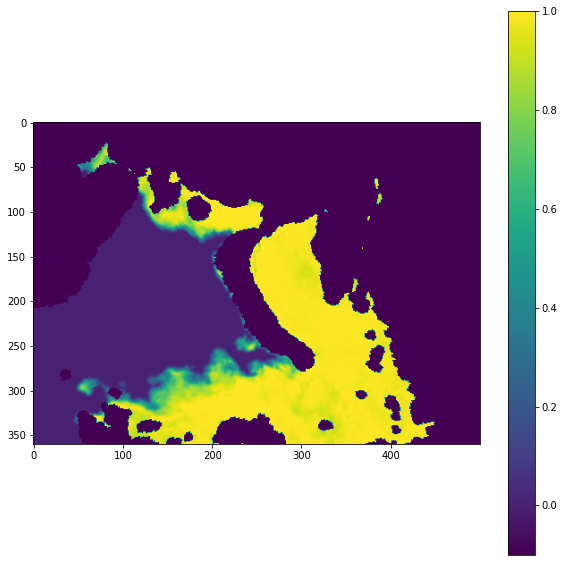

In [5]:
def preprocess_image(tensor: torch.Tensor) -> torch.Tensor:
    return (torch.nan_to_num(tensor, nan=-10.0))/100 # + grid['land']*10

plt.figure(figsize=(10,10))
axs = imshow(preprocess_image(sample["jaxa.sic"]).reshape(360, 500).detach().cpu().numpy())
plt.colorbar()

In [6]:
images_train = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(train_files)))]
images_val = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(val_files)))]
images_test = [preprocess_image(torch.load(folder_train + train_files[i])["jaxa.sic"])\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:03<00:00, 92.29it/s] 


In [7]:
images_tensor_train, images_tensor_val, images_tensor_test = torch.stack(images_train).to(device),\
                                                             torch.stack(images_val).to(device),\
                                                             torch.stack(images_test).to(device)
images_tensor_train.shape

torch.Size([1812, 360, 500])

## Model trepanation

#### Check whether NaNs of the SIC part in the same positions or not

In [8]:
images_train_raw = [torch.load(folder_train + train_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(train_files)))]

images_val_raw = [torch.load(folder_val + val_files[i])["jaxa.sic"]\
                            for i in tqdm(range(0, len(val_files)))]

def handler(data: dict):
    try:
#        print(data["jaxa.sic"])
        return data["jaxa.sic"]
    except:
#        print(data["jaxa.sic_asc"])
        return data["jaxa.sic_asc"]
    
images_test_raw = [handler(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

100%|██████████| 365/365 [00:06<00:00, 52.48it/s]


In [9]:
ref_mask = torch.isnan(images_train_raw[0])

diffs = []

for split in [images_train_raw, images_val_raw, images_test_raw]:
    data_2_check = [torch.logical_xor(torch.isnan(image), ref_mask) for image in split]
    diffs.append(data_2_check)

In [10]:
# ultimate mask correcions

diffs[2][181] = ~diffs[2][181]

diffs[0][323] = diffs[0][322]
diffs[0][987] = diffs[0][986]

In [11]:
from copy import deepcopy

ref_mask = torch.isnan(images_train_raw[0])
ultimate_mask = deepcopy(ref_mask)

for split in diffs:
    print('---')
    for i, image in enumerate(split[:]):
        if (torch.sum(image.float()) > 2*981.):
            print(i, torch.sum(image.float()))
        ultimate_mask = torch.logical_or(ultimate_mask, image)

---
457 tensor(2107.)
---
76 tensor(2075.)
---
60 tensor(2162.)
181 tensor(101124.)


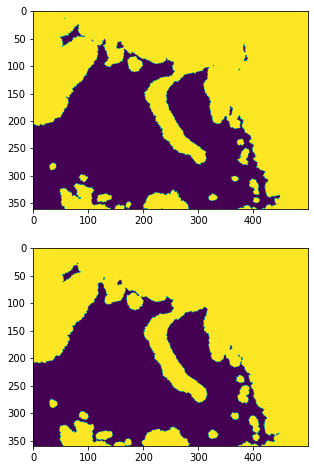

In [74]:
ref_mask = torch.isnan(images_train_raw[0])

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].imshow(ref_mask)
ax[1].imshow(ultimate_mask)
# plt.colorbar()

In [12]:
torch.save(ultimate_mask, 'mask_barents.pt')

In [8]:
ultimate_mask = torch.load('mask_barents.pt')

#### Actual experiments

In [14]:
epochs = 1000
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 5

In [84]:
images_in , images_out = load_data(batch_size, images_tensor_val, d_in, d_out)

images_in[:,-1][:, None, :, :].shape

torch.Size([8, 1, 360, 500])

In [85]:
test_output = model(images_in)
test_output.shape

torch.Size([8, 3, 360, 500])

In [97]:
sum_output_c = test_output + images_in[:,-1][:, None, :, :]
sum_output_n = test_output + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
test_output.shape

torch.Size([8, 3, 360, 500])

In [98]:
torch.all(sum_output_c == sum_output_n)

tensor(True, device='cuda:0')

In [87]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [ ]:
images_in

In [79]:
torch.all(images_in[:,-1] == images_in[:,-1][:, None, :, :].squeeze())

tensor(True, device='cuda:0')

In [83]:
images_in[0][0]

NameError: name 'images_in' is not defined

In [60]:
ultimate_mask[None, None, :].shape

torch.Size([1, 1, 360, 500])

In [98]:
ultimate_mask.to('cuda:0').shape

torch.Size([360, 500])

In [99]:
images_in[0][0].shape

torch.Size([360, 500])

TypeError: Invalid shape (75230,) for image data

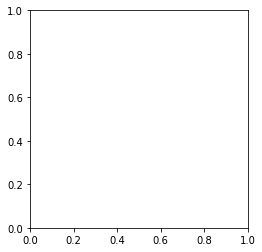

In [101]:
imshow(images_in[0][0].detach().cpu()[~ultimate_mask.cpu()])

In [15]:
def average(data: list) -> float:
    return sum(data)/len(data)

def load_data(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)

def train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion_mse = nn.MSELoss()
#weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    for epoch in range(epochs):
        model.train()
        
        images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
        optimizer.zero_grad()
        model_out = model(images_in) + images_in[:,-1, None, :, :].repeat(1, 3, 1, 1)
        
        adapted_mask = ~ultimate_mask[None, None, :].repeat(batch_size,3,1,1)
        
        loss = criterion(model_out[adapted_mask], images_out[adapted_mask])
        loss.backward() # retain_graph=True
        
#        print(model_out.shape, images_out.shape)
        
        optimizer.step()
        
        if epoch % eval_step == 0:
            with torch.no_grad():
                model.eval()

                mae_total, rmse_total, mape_total = [], [], []

                total_test_len = len(images_tensor_test)
                start_point, steps = 0, int(total_test_len/(d_in + d_out))

                for i in range(steps):
                    images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                            images_tensor_test[start_point+d_in:start_point+d_in+d_out]

                    start_point += d_in + d_out

                   # model_out = images_in[-1][None, :, :].repeat(3, 1, 1)[None, :, : , :]
                    model_out = model(images_in[None, :, :, :]) + images_in[-1].repeat(3, 1, 1)[None, :, :, :] 

                    #                print(model_out.shape)
                
                    adapted_mask = ~ultimate_mask[None, None, :].repeat(1,3,1,1)

                    loss_mse = criterion_mse(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])
                    loss_mae = criterion(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])

                    mae_total.append(loss_mae.detach().cpu().numpy())
                    rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                

                wandb.log(
                    {
                     "test/test_MAE": average(mae_total), 
                     "test/test_RMSE": average(rmse_total)
                    }
                )


            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [32]:
architecture = "ResNet_7:3_per"
i = 0
wandb.init(project="initial_tests_RE", entity="sea-ice-prediction", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

wandb: wandb version 0.15.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [33]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [34]:
from models.unet.unet.unet_model import UNet

d_in, d_out = 7, 3
batch_size = 8
lr = 1e-3
eval_step = 1
criterion = nn.L1Loss()

In [35]:
model = torch.load('resnet_test.pt').to(device)
# model = UNet(d_in, d_out).to(device)

In [36]:
epochs = 500
train(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

Epoch  0 , test MAE -  6783162.666666667
Epoch  1 , test MAE -  225629.75
Epoch  2 , test MAE -  4345.196614583333
Epoch  3 , test MAE -  0.049355884393056236
Epoch  4 , test MAE -  0.037924077775743276
Epoch  5 , test MAE -  0.0377678738700019
Epoch  6 , test MAE -  0.03704321715566847
Epoch  7 , test MAE -  0.035358809762530856
Epoch  8 , test MAE -  0.03383857674068875
Epoch  9 , test MAE -  0.03239767087830438
Epoch  10 , test MAE -  0.03280338313844469
Epoch  11 , test MAE -  0.03277125954627991
Epoch  12 , test MAE -  0.032025698158476085
Epoch  13 , test MAE -  0.03182733721203274
Epoch  14 , test MAE -  0.03121658828523424
Epoch  15 , test MAE -  0.03059485223558214
Epoch  16 , test MAE -  0.030365374353196885
Epoch  17 , test MAE -  0.030092984437942505
Epoch  18 , test MAE -  0.029945015907287598
Epoch  19 , test MAE -  0.029994845390319824
Epoch  20 , test MAE -  0.02959568632973565
Epoch  21 , test MAE -  0.02937626838684082
Epoch  22 , test MAE -  0.0295055177476671
Epoch 

Epoch  183 , test MAE -  0.027870625257492065
Epoch  184 , test MAE -  0.027972804175482854
Epoch  185 , test MAE -  0.027523365285661485
Epoch  186 , test MAE -  0.027939200401306152
Epoch  187 , test MAE -  0.02771351072523329
Epoch  188 , test MAE -  0.02784366740120782
Epoch  189 , test MAE -  0.027818991078270808
Epoch  190 , test MAE -  0.027567836973402236
Epoch  191 , test MAE -  0.02766836682955424
Epoch  192 , test MAE -  0.027571507626109652
Epoch  193 , test MAE -  0.02748273147477044
Epoch  194 , test MAE -  0.02756396432717641
Epoch  195 , test MAE -  0.027431587378184002
Epoch  196 , test MAE -  0.027556914422247145
Epoch  197 , test MAE -  0.027462864915529888
Epoch  198 , test MAE -  0.02742416328854031
Epoch  199 , test MAE -  0.02740015255080329
Epoch  200 , test MAE -  0.027382600638601515
Epoch  201 , test MAE -  0.02748825318283505
Epoch  202 , test MAE -  0.02747359209590488
Epoch  203 , test MAE -  0.02740026679303911
Epoch  204 , test MAE -  0.02748090691036648

Epoch  363 , test MAE -  0.027130830619070265
Epoch  364 , test MAE -  0.0271930197874705
Epoch  365 , test MAE -  0.027244615885946486
Epoch  366 , test MAE -  0.02713290022479163
Epoch  367 , test MAE -  0.02724553644657135
Epoch  368 , test MAE -  0.027318139870961506
Epoch  369 , test MAE -  0.027273500959078472
Epoch  370 , test MAE -  0.027154867847760517
Epoch  371 , test MAE -  0.02721125218603346
Epoch  372 , test MAE -  0.02730216085910797
Epoch  373 , test MAE -  0.02724619706471761
Epoch  374 , test MAE -  0.027201039923561945
Epoch  375 , test MAE -  0.027230986290507846
Epoch  376 , test MAE -  0.027270995908313327
Epoch  377 , test MAE -  0.027189834250344172
Epoch  378 , test MAE -  0.02712316976653205
Epoch  379 , test MAE -  0.02712147268984053
Epoch  380 , test MAE -  0.02714776661660936
Epoch  381 , test MAE -  0.027221843600273132
Epoch  382 , test MAE -  0.027230570713678997
Epoch  383 , test MAE -  0.027152722080548603
Epoch  384 , test MAE -  0.02717119952042897

In [37]:
epochs = 3200
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-4, eval_step)

Epoch  0 , test MAE -  0.027134307556682162
Epoch  1 , test MAE -  0.027096480131149292
Epoch  2 , test MAE -  0.027081610427962408
Epoch  3 , test MAE -  0.027092984981007047
Epoch  4 , test MAE -  0.027090271313985188
Epoch  5 , test MAE -  0.027078628540039062
Epoch  6 , test MAE -  0.02708097630076938
Epoch  7 , test MAE -  0.027085226443078782
Epoch  8 , test MAE -  0.02708624303340912
Epoch  9 , test MAE -  0.027082683311568365
Epoch  10 , test MAE -  0.027071224318610296
Epoch  11 , test MAE -  0.02706876728269789
Epoch  12 , test MAE -  0.02707768479983012
Epoch  13 , test MAE -  0.027078030837906733
Epoch  14 , test MAE -  0.027071802152527705
Epoch  15 , test MAE -  0.027067076828744676
Epoch  16 , test MAE -  0.02707215150197347
Epoch  17 , test MAE -  0.027073231008317735
Epoch  18 , test MAE -  0.027071840233272977
Epoch  19 , test MAE -  0.02707037991947598
Epoch  20 , test MAE -  0.027064472436904907
Epoch  21 , test MAE -  0.027070542176564533
Epoch  22 , test MAE -  0.

Epoch  182 , test MAE -  0.027069624927308824
Epoch  183 , test MAE -  0.027065806918674044
Epoch  184 , test MAE -  0.027069566978348628
Epoch  185 , test MAE -  0.02707717816034953
Epoch  186 , test MAE -  0.02707735200723012
Epoch  187 , test MAE -  0.027074229386117723
Epoch  188 , test MAE -  0.027067874868710835
Epoch  189 , test MAE -  0.027069525586234197
Epoch  190 , test MAE -  0.027071116699112788
Epoch  191 , test MAE -  0.027072581979963515
Epoch  192 , test MAE -  0.027071585257848103
Epoch  193 , test MAE -  0.027064844965934753
Epoch  194 , test MAE -  0.027071550488471985
Epoch  195 , test MAE -  0.02707635197374556
Epoch  196 , test MAE -  0.02707304060459137
Epoch  197 , test MAE -  0.02707123425271776
Epoch  198 , test MAE -  0.027072351839807298
Epoch  199 , test MAE -  0.027075517508718703
Epoch  200 , test MAE -  0.027071048816045124
Epoch  201 , test MAE -  0.027067550354533725
Epoch  202 , test MAE -  0.027072115076912776
Epoch  203 , test MAE -  0.027071490883

Epoch  362 , test MAE -  0.027063233984841242
Epoch  363 , test MAE -  0.027069835199250117
Epoch  364 , test MAE -  0.027071590224901836
Epoch  365 , test MAE -  0.02707057197888692
Epoch  366 , test MAE -  0.027072730991575453
Epoch  367 , test MAE -  0.027071250809563532
Epoch  368 , test MAE -  0.027071916394763522
Epoch  369 , test MAE -  0.02706896099779341
Epoch  370 , test MAE -  0.027066742380460102
Epoch  371 , test MAE -  0.027066444357236225
Epoch  372 , test MAE -  0.027075994345876906
Epoch  373 , test MAE -  0.0270778669251336
Epoch  374 , test MAE -  0.02707282370991177
Epoch  375 , test MAE -  0.027070469326443143
Epoch  376 , test MAE -  0.02707294954193963
Epoch  377 , test MAE -  0.027072976032892864
Epoch  378 , test MAE -  0.027068232496579487
Epoch  379 , test MAE -  0.027068156335088942
Epoch  380 , test MAE -  0.02707285351223416
Epoch  381 , test MAE -  0.027077378498183355
Epoch  382 , test MAE -  0.027076876825756498
Epoch  383 , test MAE -  0.02706947757138

Epoch  542 , test MAE -  0.027069893148210313
Epoch  543 , test MAE -  0.027069932884640165
Epoch  544 , test MAE -  0.027071527308887906
Epoch  545 , test MAE -  0.027068489127688937
Epoch  546 , test MAE -  0.027066527141465083
Epoch  547 , test MAE -  0.027071863412857056
Epoch  548 , test MAE -  0.027074563834402297
Epoch  549 , test MAE -  0.027070287201139662
Epoch  550 , test MAE -  0.027065947651863098
Epoch  551 , test MAE -  0.027068631516562566
Epoch  552 , test MAE -  0.027068320247862074
Epoch  553 , test MAE -  0.02707120610607995
Epoch  554 , test MAE -  0.02707116140259637
Epoch  555 , test MAE -  0.027067939440409344
Epoch  556 , test MAE -  0.027065704266230266
Epoch  557 , test MAE -  0.02706653376420339
Epoch  558 , test MAE -  0.02706532014740838
Epoch  559 , test MAE -  0.02706719438234965
Epoch  560 , test MAE -  0.027066313558154635
Epoch  561 , test MAE -  0.0270652174949646
Epoch  562 , test MAE -  0.027066518863042194
Epoch  563 , test MAE -  0.02706659833590

Epoch  722 , test MAE -  0.027062930994563632
Epoch  723 , test MAE -  0.027066325147946674
Epoch  724 , test MAE -  0.02707015143500434
Epoch  725 , test MAE -  0.027068464292420283
Epoch  726 , test MAE -  0.02706245415740543
Epoch  727 , test MAE -  0.027069937851693895
Epoch  728 , test MAE -  0.027071550488471985
Epoch  729 , test MAE -  0.027068275544378493
Epoch  730 , test MAE -  0.027065151267581515
Epoch  731 , test MAE -  0.02706748412715064
Epoch  732 , test MAE -  0.027063094907336764
Epoch  733 , test MAE -  0.027072831988334656
Epoch  734 , test MAE -  0.0270762476656172
Epoch  735 , test MAE -  0.02707160347037845
Epoch  736 , test MAE -  0.02706519928243425
Epoch  737 , test MAE -  0.02707382043202718
Epoch  738 , test MAE -  0.027075893349117704
Epoch  739 , test MAE -  0.027071307102839153
Epoch  740 , test MAE -  0.02707472112443712
Epoch  741 , test MAE -  0.027072644895977445
Epoch  742 , test MAE -  0.027072075340482924
Epoch  743 , test MAE -  0.0270743535624610

Epoch  902 , test MAE -  0.0270673930644989
Epoch  903 , test MAE -  0.02706868118709988
Epoch  904 , test MAE -  0.027063176035881042
Epoch  905 , test MAE -  0.0270737972524431
Epoch  906 , test MAE -  0.02707932061619229
Epoch  907 , test MAE -  0.02707660694917043
Epoch  908 , test MAE -  0.02707270450062222
Epoch  909 , test MAE -  0.027068088452021282
Epoch  910 , test MAE -  0.027074307203292847
Epoch  911 , test MAE -  0.02707795136504703
Epoch  912 , test MAE -  0.02707763181792365
Epoch  913 , test MAE -  0.027075921495755512
Epoch  914 , test MAE -  0.027075972821977403
Epoch  915 , test MAE -  0.027072169714503817
Epoch  916 , test MAE -  0.02707530392540826
Epoch  917 , test MAE -  0.02707628905773163
Epoch  918 , test MAE -  0.027082948221100703
Epoch  919 , test MAE -  0.02708254920111762
Epoch  920 , test MAE -  0.027074101898405287
Epoch  921 , test MAE -  0.027068131499820285
Epoch  922 , test MAE -  0.027080855435795255
Epoch  923 , test MAE -  0.027087352342075773
E

Epoch  1080 , test MAE -  0.027089469962649874
Epoch  1081 , test MAE -  0.027086029450098675
Epoch  1082 , test MAE -  0.027075999312930636
Epoch  1083 , test MAE -  0.027075298958354525
Epoch  1084 , test MAE -  0.027075846989949543
Epoch  1085 , test MAE -  0.02708204256163703
Epoch  1086 , test MAE -  0.02708170149061415
Epoch  1087 , test MAE -  0.027078577213817172
Epoch  1088 , test MAE -  0.027083135313457914
Epoch  1089 , test MAE -  0.027082451515727572
Epoch  1090 , test MAE -  0.027076537410418194
Epoch  1091 , test MAE -  0.027071679631869
Epoch  1092 , test MAE -  0.02706974744796753
Epoch  1093 , test MAE -  0.027072696222199336
Epoch  1094 , test MAE -  0.027077520887056988
Epoch  1095 , test MAE -  0.02707561519410875
Epoch  1096 , test MAE -  0.02707742651303609
Epoch  1097 , test MAE -  0.027073649896515742
Epoch  1098 , test MAE -  0.0270718601014879
Epoch  1099 , test MAE -  0.027070739203029208
Epoch  1100 , test MAE -  0.027066212561395433
Epoch  1101 , test MAE 

Epoch  1256 , test MAE -  0.02707538339826796
Epoch  1257 , test MAE -  0.02707702914873759
Epoch  1258 , test MAE -  0.027071755793359544
Epoch  1259 , test MAE -  0.027073750893274944
Epoch  1260 , test MAE -  0.027075067162513733
Epoch  1261 , test MAE -  0.027076376809014216
Epoch  1262 , test MAE -  0.027073961165216234
Epoch  1263 , test MAE -  0.027071204450395372
Epoch  1264 , test MAE -  0.027072482638888888
Epoch  1265 , test MAE -  0.027076449659135606
Epoch  1266 , test MAE -  0.02707627581225501
Epoch  1267 , test MAE -  0.027072747548421223
Epoch  1268 , test MAE -  0.027067249019940693
Epoch  1269 , test MAE -  0.0270719975233078
Epoch  1270 , test MAE -  0.027071451147397358
Epoch  1271 , test MAE -  0.02707615660296546
Epoch  1272 , test MAE -  0.02707734704017639
Epoch  1273 , test MAE -  0.02707143293486701
Epoch  1274 , test MAE -  0.02707069284386105
Epoch  1275 , test MAE -  0.027074625094731648
Epoch  1276 , test MAE -  0.02707601586977641
Epoch  1277 , test MAE 

Epoch  1432 , test MAE -  0.027065449290805392
Epoch  1433 , test MAE -  0.027065750625398424
Epoch  1434 , test MAE -  0.027067275510893926
Epoch  1435 , test MAE -  0.027068694432576496
Epoch  1436 , test MAE -  0.02706806692812178
Epoch  1437 , test MAE -  0.02706682350900438
Epoch  1438 , test MAE -  0.0270658897029029
Epoch  1439 , test MAE -  0.02706707351737552
Epoch  1440 , test MAE -  0.02706716623571184
Epoch  1441 , test MAE -  0.02706655694378747
Epoch  1442 , test MAE -  0.02706879046228197
Epoch  1443 , test MAE -  0.02707128392325507
Epoch  1444 , test MAE -  0.02707506881819831
Epoch  1445 , test MAE -  0.0270724528365665
Epoch  1446 , test MAE -  0.027072555489010282
Epoch  1447 , test MAE -  0.027076934774716694
Epoch  1448 , test MAE -  0.027079855402310688
Epoch  1449 , test MAE -  0.02707894312010871
Epoch  1450 , test MAE -  0.02707102398077647
Epoch  1451 , test MAE -  0.027069995800654095
Epoch  1452 , test MAE -  0.02707900106906891
Epoch  1453 , test MAE -  0.

Epoch  1609 , test MAE -  0.02707303563753764
Epoch  1610 , test MAE -  0.027075848645634122
Epoch  1611 , test MAE -  0.027075780762566462
Epoch  1612 , test MAE -  0.027069391475783453
Epoch  1613 , test MAE -  0.02706824905342526
Epoch  1614 , test MAE -  0.027067904671033222
Epoch  1615 , test MAE -  0.027071651485231187
Epoch  1616 , test MAE -  0.02707282370991177
Epoch  1617 , test MAE -  0.027069663008054096
Epoch  1618 , test MAE -  0.02706778049468994
Epoch  1619 , test MAE -  0.02706928054491679
Epoch  1620 , test MAE -  0.027069219284587435
Epoch  1621 , test MAE -  0.02706682516468896
Epoch  1622 , test MAE -  0.027067126499281988
Epoch  1623 , test MAE -  0.027068970931900874
Epoch  1624 , test MAE -  0.027068399720721774
Epoch  1625 , test MAE -  0.027067090074221294
Epoch  1626 , test MAE -  0.027067214250564575
Epoch  1627 , test MAE -  0.027064800262451172
Epoch  1628 , test MAE -  0.027066730790668063
Epoch  1629 , test MAE -  0.027065601613786485
Epoch  1630 , test 

Epoch  1785 , test MAE -  0.02707172433535258
Epoch  1786 , test MAE -  0.027071572012371488
Epoch  1787 , test MAE -  0.02707374758190579
Epoch  1788 , test MAE -  0.027071838577588398
Epoch  1789 , test MAE -  0.027067100008328755
Epoch  1790 , test MAE -  0.027069744136598375
Epoch  1791 , test MAE -  0.027078496085272893
Epoch  1792 , test MAE -  0.027081852157910664
Epoch  1793 , test MAE -  0.02707938353220622
Epoch  1794 , test MAE -  0.027077106965912714
Epoch  1795 , test MAE -  0.027069901426633198
Epoch  1796 , test MAE -  0.02707567148738437
Epoch  1797 , test MAE -  0.027080655097961426
Epoch  1798 , test MAE -  0.027084001236491732
Epoch  1799 , test MAE -  0.027080381910006206
Epoch  1800 , test MAE -  0.027071853478749592
Epoch  1801 , test MAE -  0.027069513996442158
Epoch  1802 , test MAE -  0.027076611916224163
Epoch  1803 , test MAE -  0.027079105377197266
Epoch  1804 , test MAE -  0.027081184917026095
Epoch  1805 , test MAE -  0.02708197467856937
Epoch  1806 , test

Epoch  1961 , test MAE -  0.02706488801373376
Epoch  1962 , test MAE -  0.027065295312139723
Epoch  1963 , test MAE -  0.027068475882212322
Epoch  1964 , test MAE -  0.02706489132510291
Epoch  1965 , test MAE -  0.027062599857648213
Epoch  1966 , test MAE -  0.02706959843635559
Epoch  1967 , test MAE -  0.02707102232509189
Epoch  1968 , test MAE -  0.02707139982117547
Epoch  1969 , test MAE -  0.027069760693444148
Epoch  1970 , test MAE -  0.027066330115000408
Epoch  1971 , test MAE -  0.02706545094648997
Epoch  1972 , test MAE -  0.027067419555452134
Epoch  1973 , test MAE -  0.02706634004910787
Epoch  1974 , test MAE -  0.027064644628100924
Epoch  1975 , test MAE -  0.02706289953655667
Epoch  1976 , test MAE -  0.0270644078652064
Epoch  1977 , test MAE -  0.02706727882226308
Epoch  1978 , test MAE -  0.027063750558429293
Epoch  1979 , test MAE -  0.027066932784186468
Epoch  1980 , test MAE -  0.02706846098105113
Epoch  1981 , test MAE -  0.027064919471740723
Epoch  1982 , test MAE - 

Epoch  2137 , test MAE -  0.02706456846661038
Epoch  2138 , test MAE -  0.027065560221672058
Epoch  2139 , test MAE -  0.0270673715405994
Epoch  2140 , test MAE -  0.027065457569228277
Epoch  2141 , test MAE -  0.027066149645381503
Epoch  2142 , test MAE -  0.027068257331848145
Epoch  2143 , test MAE -  0.02706838481956058
Epoch  2144 , test MAE -  0.02706360982524024
Epoch  2145 , test MAE -  0.027069207694795396
Epoch  2146 , test MAE -  0.027072691255145602
Epoch  2147 , test MAE -  0.027071078618367512
Epoch  2148 , test MAE -  0.027070724301868014
Epoch  2149 , test MAE -  0.02706941134399838
Epoch  2150 , test MAE -  0.02707083523273468
Epoch  2151 , test MAE -  0.02706947426001231
Epoch  2152 , test MAE -  0.02707587679227193
Epoch  2153 , test MAE -  0.027076890071233112
Epoch  2154 , test MAE -  0.02707158691353268
Epoch  2155 , test MAE -  0.02707560360431671
Epoch  2156 , test MAE -  0.0270749032497406
Epoch  2157 , test MAE -  0.027077459626727633
Epoch  2158 , test MAE -  

Epoch  2313 , test MAE -  0.027069038814968534
Epoch  2314 , test MAE -  0.027069507373703852
Epoch  2315 , test MAE -  0.02706888649198744
Epoch  2316 , test MAE -  0.027065757248136733
Epoch  2317 , test MAE -  0.027070365018314786
Epoch  2318 , test MAE -  0.027074187994003296
Epoch  2319 , test MAE -  0.0270722723669476
Epoch  2320 , test MAE -  0.0270705156856113
Epoch  2321 , test MAE -  0.027069119943512812
Epoch  2322 , test MAE -  0.027070045471191406
Epoch  2323 , test MAE -  0.02706301709016164
Epoch  2324 , test MAE -  0.027071244186825223
Epoch  2325 , test MAE -  0.027074717813067965
Epoch  2326 , test MAE -  0.027074323760138616
Epoch  2327 , test MAE -  0.027069242464171514
Epoch  2328 , test MAE -  0.027065340015623305
Epoch  2329 , test MAE -  0.027077077163590327
Epoch  2330 , test MAE -  0.027081042528152466
Epoch  2331 , test MAE -  0.027077260944578383
Epoch  2332 , test MAE -  0.027075141668319702
Epoch  2333 , test MAE -  0.02707471450169881
Epoch  2334 , test M

Epoch  2489 , test MAE -  0.02707465820842319
Epoch  2490 , test MAE -  0.027070944507916767
Epoch  2491 , test MAE -  0.02707134187221527
Epoch  2492 , test MAE -  0.0270758718252182
Epoch  2493 , test MAE -  0.02707174751493666
Epoch  2494 , test MAE -  0.0270711084206899
Epoch  2495 , test MAE -  0.02707069781091478
Epoch  2496 , test MAE -  0.027071081929736666
Epoch  2497 , test MAE -  0.027067879835764568
Epoch  2498 , test MAE -  0.027071643206808303
Epoch  2499 , test MAE -  0.02707426581117842
Epoch  2500 , test MAE -  0.02707833382818434
Epoch  2501 , test MAE -  0.027076343695322674
Epoch  2502 , test MAE -  0.027068095074759588
Epoch  2503 , test MAE -  0.027069772283236187
Epoch  2504 , test MAE -  0.0270767824517356
Epoch  2505 , test MAE -  0.027075464526812237
Epoch  2506 , test MAE -  0.027071775661574468
Epoch  2507 , test MAE -  0.027070404754744634
Epoch  2508 , test MAE -  0.02706625560919444
Epoch  2509 , test MAE -  0.027071520686149597
Epoch  2510 , test MAE -  

Epoch  2665 , test MAE -  0.02706781029701233
Epoch  2666 , test MAE -  0.0270726482073466
Epoch  2667 , test MAE -  0.02707568969991472
Epoch  2668 , test MAE -  0.027078486151165433
Epoch  2669 , test MAE -  0.027076426479551528
Epoch  2670 , test MAE -  0.027067060271898907
Epoch  2671 , test MAE -  0.02707140975528293
Epoch  2672 , test MAE -  0.027078111966451008
Epoch  2673 , test MAE -  0.027076842056380376
Epoch  2674 , test MAE -  0.027069783873028226
Epoch  2675 , test MAE -  0.02706574069129096
Epoch  2676 , test MAE -  0.027072992589738634
Epoch  2677 , test MAE -  0.027075264188978408
Epoch  2678 , test MAE -  0.02707403235965305
Epoch  2679 , test MAE -  0.027069669630792405
Epoch  2680 , test MAE -  0.02706999911202325
Epoch  2681 , test MAE -  0.0270729660987854
Epoch  2682 , test MAE -  0.027074019114176433
Epoch  2683 , test MAE -  0.027071722679668002
Epoch  2684 , test MAE -  0.027071702811453078
Epoch  2685 , test MAE -  0.02706572413444519
Epoch  2686 , test MAE -

Epoch  2841 , test MAE -  0.027072288923793368
Epoch  2842 , test MAE -  0.02707709040906694
Epoch  2843 , test MAE -  0.027075098620520696
Epoch  2844 , test MAE -  0.027075449625651043
Epoch  2845 , test MAE -  0.027073504196272954
Epoch  2846 , test MAE -  0.027066523830095928
Epoch  2847 , test MAE -  0.0270669377512402
Epoch  2848 , test MAE -  0.02706810997592078
Epoch  2849 , test MAE -  0.027065094974305894
Epoch  2850 , test MAE -  0.0270690338479148
Epoch  2851 , test MAE -  0.027069768971867032
Epoch  2852 , test MAE -  0.027067931161986455
Epoch  2853 , test MAE -  0.027066651317808364
Epoch  2854 , test MAE -  0.02706840799914466
Epoch  2855 , test MAE -  0.02706799242231581
Epoch  2856 , test MAE -  0.027071944541401334
Epoch  2857 , test MAE -  0.02707103391488393
Epoch  2858 , test MAE -  0.02706670926676856
Epoch  2859 , test MAE -  0.027066479126612347
Epoch  2860 , test MAE -  0.027066889736387465
Epoch  2861 , test MAE -  0.027063939306471083
Epoch  2862 , test MAE 

Epoch  3018 , test MAE -  0.02707130213578542
Epoch  3019 , test MAE -  0.027065919505225286
Epoch  3020 , test MAE -  0.027070156402058072
Epoch  3021 , test MAE -  0.027075062195460003
Epoch  3022 , test MAE -  0.027073197894626193
Epoch  3023 , test MAE -  0.027068742447429232
Epoch  3024 , test MAE -  0.02706578539477454
Epoch  3025 , test MAE -  0.027073226041264005
Epoch  3026 , test MAE -  0.027075727780659992
Epoch  3027 , test MAE -  0.027072745892736647
Epoch  3028 , test MAE -  0.027072820398542616
Epoch  3029 , test MAE -  0.02706994778580136
Epoch  3030 , test MAE -  0.027071168025334675
Epoch  3031 , test MAE -  0.027073300547069974
Epoch  3032 , test MAE -  0.027075999312930636
Epoch  3033 , test MAE -  0.027076138390435114
Epoch  3034 , test MAE -  0.0270736383067237
Epoch  3035 , test MAE -  0.027064856555726793
Epoch  3036 , test MAE -  0.02707275582684411
Epoch  3037 , test MAE -  0.02708137532075246
Epoch  3038 , test MAE -  0.0270808521244261
Epoch  3039 , test MAE

Epoch  3194 , test MAE -  0.02706760002507104
Epoch  3195 , test MAE -  0.02706813481118944
Epoch  3196 , test MAE -  0.02706831031375461
Epoch  3197 , test MAE -  0.027069606714778476
Epoch  3198 , test MAE -  0.027073692944314744
Epoch  3199 , test MAE -  0.02707087496916453


In [ ]:
epochs = 5000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-5, eval_step)

In [159]:
images_in, images_out = load_data(1, images_tensor_test, d_in, d_out)

In [180]:
start_point = 0


images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                            images_tensor_test[start_point+d_in:start_point+d_in+d_out]

In [181]:
adapted_mask = ~ultimate_mask[None, None, :].repeat(1,3,1,1)

In [202]:
pred = model(images_in[None, :, :, :]) + images_in[-1, :]

In [204]:
criterion(pred[adapted_mask], images_out[None, :, :, :][adapted_mask])

tensor(0.0389, device='cuda:0', grad_fn=<MeanBackward0>)

In [177]:
model(images_in)[0][0]

tensor([[0.0045, 0.0049, 0.0076,  ..., 0.0074, 0.0034, 0.0032],
        [0.0016, 0.0058, 0.0046,  ..., 0.0059, 0.0055, 0.0040],
        [0.0038, 0.0046, 0.0149,  ..., 0.0167, 0.0062, 0.0052],
        ...,
        [0.0002, 0.0003, 0.0003,  ..., 0.0138, 0.0049, 0.0056],
        [0.0009, 0.0003, 0.0004,  ..., 0.0125, 0.0053, 0.0045],
        [0.0005, 0.0004, 0.0002,  ..., 0.0036, 0.0022, 0.0048]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [210]:
pred[adapted_mask]

tensor([0.4843, 0.5319, 0.5237,  ..., 0.9147, 0.9127, 0.9112], device='cuda:0',
       grad_fn=<IndexBackward0>)

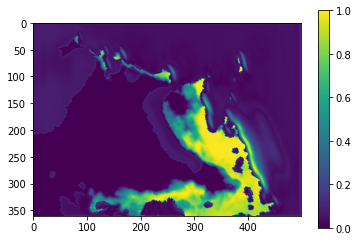

In [216]:
plt.imshow(abs(pred[0][0]).detach().cpu())
plt.clim(0,1)
plt.colorbar()

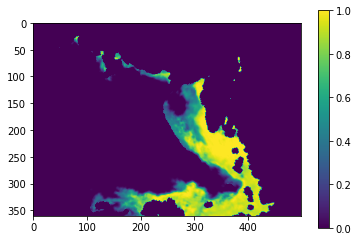

In [218]:
plt.imshow(images_out[None, :, :, :][0][0].detach().cpu())
plt.clim(0,1)
plt.colorbar()

In [217]:
images_out[None, :, :, :][0][0]

tensor([[-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1000, -0.1000, -0.1000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1000, -0.1000, -0.1000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1000, -0.1000, -0.1000]],
       device='cuda:0')

In [163]:
images_out.shape

torch.Size([1, 3, 360, 500])

In [73]:
preds, gts = [], []
with torch.no_grad():
    model.eval()

    mae_total, rmse_total, mape_total = [], [], []

    total_test_len = len(images_tensor_test)
    start_point, steps = 0, int(total_test_len/(d_in + d_out))

    for i in range(steps):
        images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                images_tensor_test[start_point+d_in:start_point+d_in+d_out]
        
        
        
        start_point += d_in + d_out

        model_out = images_in[-1][None, :, :].repeat(3, 1, 1)[None, :, : , :]
       # model_out = model(images_in[None, :, :, :]) + images_in[-1].repeat(3, 1, 1)[None, :, :, :] 

        #                print(model_out.shape)

        
        adapted_mask = ~ultimate_mask[None, None, :].repeat(1,3,1,1)

     
        loss_mae = criterion(model_out[adapted_mask], images_out[None, :, :, :][adapted_mask])

        mae_total.append(loss_mae.detach().cpu().numpy())
       
    print(average(mae_total))

0.009959518909454346


In [154]:
epochs = 10000
train(model, criterion, d_in, d_out, epochs, batch_size, 1e-6, eval_step)

Epoch  0 , test MAE -  0.022467308574252658
Epoch  1 , test MAE -  0.022497524817784626
Epoch  2 , test MAE -  0.022455086310704548
Epoch  3 , test MAE -  0.022518886460198298
Epoch  4 , test MAE -  0.022585660219192505
Epoch  5 , test MAE -  0.022553137607044645
Epoch  6 , test MAE -  0.02252878248691559
Epoch  7 , test MAE -  0.022502145833439298
Epoch  8 , test MAE -  0.022484843929608662
Epoch  9 , test MAE -  0.022462765375773113
Epoch  10 , test MAE -  0.022411892811457317
Epoch  11 , test MAE -  0.022386031018363103
Epoch  12 , test MAE -  0.022359525163968403
Epoch  13 , test MAE -  0.022361540132098727
Epoch  14 , test MAE -  0.022356309824519686
Epoch  15 , test MAE -  0.022388809257083468
Epoch  16 , test MAE -  0.022384087244669598
Epoch  17 , test MAE -  0.02237514654795329
Epoch  18 , test MAE -  0.022384289238188002
Epoch  19 , test MAE -  0.02232729395230611
Epoch  20 , test MAE -  0.02231191595395406
Epoch  21 , test MAE -  0.022322929567760892
Epoch  22 , test MAE -  

Epoch  182 , test MAE -  0.02238353755739
Epoch  183 , test MAE -  0.022324161397086248
Epoch  184 , test MAE -  0.02228546142578125
Epoch  185 , test MAE -  0.022280284100108676
Epoch  186 , test MAE -  0.022267737322383456
Epoch  187 , test MAE -  0.022262434164683025
Epoch  188 , test MAE -  0.022250200311342876
Epoch  189 , test MAE -  0.022250193688604567
Epoch  190 , test MAE -  0.02222913669215308
Epoch  191 , test MAE -  0.022237843937344022
Epoch  192 , test MAE -  0.022232787476645574
Epoch  193 , test MAE -  0.02222203214963277
Epoch  194 , test MAE -  0.022261896067195468
Epoch  195 , test MAE -  0.022279209560818143
Epoch  196 , test MAE -  0.02226839131779141
Epoch  197 , test MAE -  0.022277456190851
Epoch  198 , test MAE -  0.0223025961054696
Epoch  199 , test MAE -  0.022291794419288635
Epoch  200 , test MAE -  0.02229105101691352
Epoch  201 , test MAE -  0.02227256695429484
Epoch  202 , test MAE -  0.022256235281626385
Epoch  203 , test MAE -  0.022243536180920072
Epo

Epoch  362 , test MAE -  0.022310362921820745
Epoch  363 , test MAE -  0.022393887241681416
Epoch  364 , test MAE -  0.022431431545151606
Epoch  365 , test MAE -  0.022402579585711162
Epoch  366 , test MAE -  0.022367502252260845
Epoch  367 , test MAE -  0.022317250569661457
Epoch  368 , test MAE -  0.022310591406292386
Epoch  369 , test MAE -  0.02242467635207706
Epoch  370 , test MAE -  0.022407780090967815
Epoch  371 , test MAE -  0.022404273351033527
Epoch  372 , test MAE -  0.022434535953733657
Epoch  373 , test MAE -  0.0224084390534295
Epoch  374 , test MAE -  0.022378504276275635
Epoch  375 , test MAE -  0.02233880592717065
Epoch  376 , test MAE -  0.022338835729493037
Epoch  377 , test MAE -  0.02230201330449846
Epoch  378 , test MAE -  0.022336835662523907
Epoch  379 , test MAE -  0.02231958011786143
Epoch  380 , test MAE -  0.02235674692524804
Epoch  381 , test MAE -  0.02232424749268426
Epoch  382 , test MAE -  0.022318397959073383
Epoch  383 , test MAE -  0.022300425502989

Epoch  542 , test MAE -  0.02235198186503516
Epoch  543 , test MAE -  0.022326618432998657
Epoch  544 , test MAE -  0.02230007780922784
Epoch  545 , test MAE -  0.022262016932169598
Epoch  546 , test MAE -  0.022259096304575603
Epoch  547 , test MAE -  0.022551069657007854
Epoch  548 , test MAE -  0.022525638341903687
Epoch  549 , test MAE -  0.02245278325345781
Epoch  550 , test MAE -  0.022386741307046678
Epoch  551 , test MAE -  0.022364714079433017
Epoch  552 , test MAE -  0.022357523441314697
Epoch  553 , test MAE -  0.022366738981670804
Epoch  554 , test MAE -  0.02239357100592719
Epoch  555 , test MAE -  0.022360300024350483
Epoch  556 , test MAE -  0.022328737709257338
Epoch  557 , test MAE -  0.022299246655570135
Epoch  558 , test MAE -  0.02229430940416124
Epoch  559 , test MAE -  0.022316725717650518
Epoch  560 , test MAE -  0.022265591555171542
Epoch  561 , test MAE -  0.022268330057462055
Epoch  562 , test MAE -  0.02223715351687537
Epoch  563 , test MAE -  0.0222323073281

Epoch  722 , test MAE -  0.0222248633702596
Epoch  723 , test MAE -  0.02222667634487152
Epoch  724 , test MAE -  0.022227353519863553
Epoch  725 , test MAE -  0.022210246986813016
Epoch  726 , test MAE -  0.022237204843097262
Epoch  727 , test MAE -  0.022347410519917805
Epoch  728 , test MAE -  0.022329030765427485
Epoch  729 , test MAE -  0.022262303365601435
Epoch  730 , test MAE -  0.02224705119927724
Epoch  731 , test MAE -  0.022223613328403898
Epoch  732 , test MAE -  0.022244988216294184
Epoch  733 , test MAE -  0.022265220681826275
Epoch  734 , test MAE -  0.02225606640179952
Epoch  735 , test MAE -  0.022244218322965834
Epoch  736 , test MAE -  0.022221230798297457
Epoch  737 , test MAE -  0.022220692700809903
Epoch  738 , test MAE -  0.02219999995496538
Epoch  739 , test MAE -  0.02219460904598236
Epoch  740 , test MAE -  0.02228798634476132
Epoch  741 , test MAE -  0.022267020410961576
Epoch  742 , test MAE -  0.022322307030359905
Epoch  743 , test MAE -  0.022277149889204

Epoch  902 , test MAE -  0.022244269649187725
Epoch  903 , test MAE -  0.022222210963567097
Epoch  904 , test MAE -  0.02222773267163171
Epoch  905 , test MAE -  0.02222824262248145
Epoch  906 , test MAE -  0.02225495543744829
Epoch  907 , test MAE -  0.022242107325130038
Epoch  908 , test MAE -  0.022257044911384583
Epoch  909 , test MAE -  0.02228397296534644
Epoch  910 , test MAE -  0.0222828123304579
Epoch  911 , test MAE -  0.022281116909450956
Epoch  912 , test MAE -  0.022306607829199895
Epoch  913 , test MAE -  0.022265132930543687
Epoch  914 , test MAE -  0.02226567268371582
Epoch  915 , test MAE -  0.022247248225741915
Epoch  916 , test MAE -  0.02222506867514716
Epoch  917 , test MAE -  0.0221996588839425
Epoch  918 , test MAE -  0.02220404975944095
Epoch  919 , test MAE -  0.022204190492630005
Epoch  920 , test MAE -  0.022219412856631808
Epoch  921 , test MAE -  0.022182539105415344
Epoch  922 , test MAE -  0.02223187353875902
Epoch  923 , test MAE -  0.022194162011146545


Epoch  1080 , test MAE -  0.022422512372334797
Epoch  1081 , test MAE -  0.022392173608144123
Epoch  1082 , test MAE -  0.022359290056758456
Epoch  1083 , test MAE -  0.022322843472162884
Epoch  1084 , test MAE -  0.02232877082294888
Epoch  1085 , test MAE -  0.022466416160265606
Epoch  1086 , test MAE -  0.023065436217519972
Epoch  1087 , test MAE -  0.022928236259354487
Epoch  1088 , test MAE -  0.022784112228287592
Epoch  1089 , test MAE -  0.022780353824297588
Epoch  1090 , test MAE -  0.022745079464382596
Epoch  1091 , test MAE -  0.022655397653579712
Epoch  1092 , test MAE -  0.023137200209829543
Epoch  1093 , test MAE -  0.023067389925320942
Epoch  1094 , test MAE -  0.02299824357032776
Epoch  1095 , test MAE -  0.02287921640608046
Epoch  1096 , test MAE -  0.022839408781793382
Epoch  1097 , test MAE -  0.022712614801194932
Epoch  1098 , test MAE -  0.022631635268529255
Epoch  1099 , test MAE -  0.022591431935628254
Epoch  1100 , test MAE -  0.02254258096218109
Epoch  1101 , tes

Epoch  1256 , test MAE -  0.02226759824487898
Epoch  1257 , test MAE -  0.022260803315374587
Epoch  1258 , test MAE -  0.022233722938431635
Epoch  1259 , test MAE -  0.022615020473798115
Epoch  1260 , test MAE -  0.022601972023646038
Epoch  1261 , test MAE -  0.02264271014266544
Epoch  1262 , test MAE -  0.02258958750300937
Epoch  1263 , test MAE -  0.022530161672168307
Epoch  1264 , test MAE -  0.022444526354471844
Epoch  1265 , test MAE -  0.02238566842344072
Epoch  1266 , test MAE -  0.02238819334242079
Epoch  1267 , test MAE -  0.022351241774029203
Epoch  1268 , test MAE -  0.02228863537311554
Epoch  1269 , test MAE -  0.022274633248647053
Epoch  1270 , test MAE -  0.022261750366952684
Epoch  1271 , test MAE -  0.022298029727405973
Epoch  1272 , test MAE -  0.022417063514391582
Epoch  1273 , test MAE -  0.022378371821509466
Epoch  1274 , test MAE -  0.02237492799758911
Epoch  1275 , test MAE -  0.022389352321624756
Epoch  1276 , test MAE -  0.022353404098086886
Epoch  1277 , test M

Epoch  1432 , test MAE -  0.022354609436459012
Epoch  1433 , test MAE -  0.022308376100328233
Epoch  1434 , test MAE -  0.022321758998764887
Epoch  1435 , test MAE -  0.02234268022908105
Epoch  1436 , test MAE -  0.022437219818433125
Epoch  1437 , test MAE -  0.02235270043214162
Epoch  1438 , test MAE -  0.02233919335736169
Epoch  1439 , test MAE -  0.022334885266092088
Epoch  1440 , test MAE -  0.023343783285882738
Epoch  1441 , test MAE -  0.023158364825778537
Epoch  1442 , test MAE -  0.022947683930397034
Epoch  1443 , test MAE -  0.022824785775608487
Epoch  1444 , test MAE -  0.022830012771818373
Epoch  1445 , test MAE -  0.022702447242206998
Epoch  1446 , test MAE -  0.022703041632970173
Epoch  1447 , test MAE -  0.022650616036521062
Epoch  1448 , test MAE -  0.02262737684779697
Epoch  1449 , test MAE -  0.022537074155277677
Epoch  1450 , test MAE -  0.022500294778082106
Epoch  1451 , test MAE -  0.022521994180149503
Epoch  1452 , test MAE -  0.022580337193277147
Epoch  1453 , tes

Epoch  1608 , test MAE -  0.022268826762835186
Epoch  1609 , test MAE -  0.0224890626139111
Epoch  1610 , test MAE -  0.022437435057428148
Epoch  1611 , test MAE -  0.022414171033435397
Epoch  1612 , test MAE -  0.02240819897916582
Epoch  1613 , test MAE -  0.022358881102667913
Epoch  1614 , test MAE -  0.02230647371874915
Epoch  1615 , test MAE -  0.022279926472240023
Epoch  1616 , test MAE -  0.022236777676476374
Epoch  1617 , test MAE -  0.022233376900355022
Epoch  1618 , test MAE -  0.022239511211713154
Epoch  1619 , test MAE -  0.022227300537957087
Epoch  1620 , test MAE -  0.022178111804856196
Epoch  1621 , test MAE -  0.02218683726257748
Epoch  1622 , test MAE -  0.02283488545152876
Epoch  1623 , test MAE -  0.023083017932044134
Epoch  1624 , test MAE -  0.02293156087398529
Epoch  1625 , test MAE -  0.02281409502029419
Epoch  1626 , test MAE -  0.023481825987497967
Epoch  1627 , test MAE -  0.023354629675547283
Epoch  1628 , test MAE -  0.02323421835899353
Epoch  1629 , test MAE

Epoch  1784 , test MAE -  0.022127047181129456
Epoch  1785 , test MAE -  0.022120479080412123
Epoch  1786 , test MAE -  0.022148619095484417
Epoch  1787 , test MAE -  0.02216479182243347
Epoch  1788 , test MAE -  0.02214410901069641
Epoch  1789 , test MAE -  0.02216836478975084
Epoch  1790 , test MAE -  0.02236409319771661
Epoch  1791 , test MAE -  0.022344037890434265
Epoch  1792 , test MAE -  0.02245473364988963
Epoch  1793 , test MAE -  0.022398508257336087
Epoch  1794 , test MAE -  0.02234312229686313
Epoch  1795 , test MAE -  0.022415076692899067
Epoch  1796 , test MAE -  0.02243198619948493
Epoch  1797 , test MAE -  0.022384941577911377
Epoch  1798 , test MAE -  0.022391814324590895
Epoch  1799 , test MAE -  0.02238109873400794
Epoch  1800 , test MAE -  0.022573328680462308
Epoch  1801 , test MAE -  0.022605448961257935
Epoch  1802 , test MAE -  0.022518818577130634
Epoch  1803 , test MAE -  0.022460927565892536
Epoch  1804 , test MAE -  0.022538421882523432
Epoch  1805 , test MA

Epoch  1960 , test MAE -  0.022484279341167875
Epoch  1961 , test MAE -  0.022459776865111455
Epoch  1962 , test MAE -  0.022399819559521146
Epoch  1963 , test MAE -  0.022337156865331862
Epoch  1964 , test MAE -  0.02230370044708252
Epoch  1965 , test MAE -  0.022359639406204224
Epoch  1966 , test MAE -  0.022308071454366047
Epoch  1967 , test MAE -  0.022343011365996465
Epoch  1968 , test MAE -  0.02230221198664771
Epoch  1969 , test MAE -  0.022273134854104783
Epoch  1970 , test MAE -  0.02227182189623515
Epoch  1971 , test MAE -  0.022314376301235624
Epoch  1972 , test MAE -  0.022287343939145405
Epoch  1973 , test MAE -  0.02227617469098833
Epoch  1974 , test MAE -  0.02223762207561069
Epoch  1975 , test MAE -  0.022212694088617962
Epoch  1976 , test MAE -  0.02219243844350179
Epoch  1977 , test MAE -  0.022560679250293307
Epoch  1978 , test MAE -  0.022481103738149006
Epoch  1979 , test MAE -  0.022427923149532743
Epoch  1980 , test MAE -  0.02236730357011159
Epoch  1981 , test M

Epoch  2136 , test MAE -  0.022338135374916926
Epoch  2137 , test MAE -  0.02230363753106859
Epoch  2138 , test MAE -  0.02231501042842865
Epoch  2139 , test MAE -  0.02227245933479733
Epoch  2140 , test MAE -  0.02229970693588257
Epoch  2141 , test MAE -  0.022294531265894573
Epoch  2142 , test MAE -  0.02227183348602719
Epoch  2143 , test MAE -  0.022325129972563848
Epoch  2144 , test MAE -  0.022305015060636733
Epoch  2145 , test MAE -  0.022290489739841886
Epoch  2146 , test MAE -  0.022283446457650926
Epoch  2147 , test MAE -  0.022263445787959628
Epoch  2148 , test MAE -  0.022244398792584736
Epoch  2149 , test MAE -  0.022241037752893236
Epoch  2150 , test MAE -  0.022224573625458613
Epoch  2151 , test MAE -  0.022238239645957947
Epoch  2152 , test MAE -  0.02226224210527208
Epoch  2153 , test MAE -  0.02225698365105523
Epoch  2154 , test MAE -  0.02224065860112508
Epoch  2155 , test MAE -  0.022216250499089558
Epoch  2156 , test MAE -  0.022242668602201674
Epoch  2157 , test MA

Epoch  2312 , test MAE -  0.022357129388385348
Epoch  2313 , test MAE -  0.022323338521851435
Epoch  2314 , test MAE -  0.02233940859635671
Epoch  2315 , test MAE -  0.022348402274979487
Epoch  2316 , test MAE -  0.02255205147796207
Epoch  2317 , test MAE -  0.02276728053887685
Epoch  2318 , test MAE -  0.02269984119468265
Epoch  2319 , test MAE -  0.02264661259121365
Epoch  2320 , test MAE -  0.02257277402612898
Epoch  2321 , test MAE -  0.02250303824742635
Epoch  2322 , test MAE -  0.022472752465142146
Epoch  2323 , test MAE -  0.02244354122214847
Epoch  2324 , test MAE -  0.02245999210410648
Epoch  2325 , test MAE -  0.02239287065135108
Epoch  2326 , test MAE -  0.02235379980670081
Epoch  2327 , test MAE -  0.02247302896446652
Epoch  2328 , test MAE -  0.022440416945351496
Epoch  2329 , test MAE -  0.022418338391515944
Epoch  2330 , test MAE -  0.022350822885831196
Epoch  2331 , test MAE -  0.022381391790178087
Epoch  2332 , test MAE -  0.022306357820828755
Epoch  2333 , test MAE - 

Epoch  2488 , test MAE -  0.022184756067064073
Epoch  2489 , test MAE -  0.02217647929986318
Epoch  2490 , test MAE -  0.02218417161040836
Epoch  2491 , test MAE -  0.022152703669336107
Epoch  2492 , test MAE -  0.022266296876801386
Epoch  2493 , test MAE -  0.022261636124716863
Epoch  2494 , test MAE -  0.022268477413389418
Epoch  2495 , test MAE -  0.02251123057471381
Epoch  2496 , test MAE -  0.022476699617173936
Epoch  2497 , test MAE -  0.0224068197939131
Epoch  2498 , test MAE -  0.022365209129121568
Epoch  2499 , test MAE -  0.02233532236682044
Epoch  2500 , test MAE -  0.02239805625544654
Epoch  2501 , test MAE -  0.02239174975289239
Epoch  2502 , test MAE -  0.022359970543119643
Epoch  2503 , test MAE -  0.022321144739786785
Epoch  2504 , test MAE -  0.022312311662567988
Epoch  2505 , test MAE -  0.022265369693438213
Epoch  2506 , test MAE -  0.022259493668874104
Epoch  2507 , test MAE -  0.0222259693675571
Epoch  2508 , test MAE -  0.02221673561467065
Epoch  2509 , test MAE -

Epoch  2664 , test MAE -  0.02226872245470683
Epoch  2665 , test MAE -  0.02227471437719133
Epoch  2666 , test MAE -  0.022273391485214233
Epoch  2667 , test MAE -  0.022255503469043307
Epoch  2668 , test MAE -  0.022266099850336712
Epoch  2669 , test MAE -  0.02226023541556464
Epoch  2670 , test MAE -  0.02227964500586192
Epoch  2671 , test MAE -  0.022240491376982793
Epoch  2672 , test MAE -  0.022224355075094435
Epoch  2673 , test MAE -  0.022185282574759588
Epoch  2674 , test MAE -  0.022223124901453655
Epoch  2675 , test MAE -  0.022214098109139338
Epoch  2676 , test MAE -  0.022185963061120775
Epoch  2677 , test MAE -  0.022208601236343384
Epoch  2678 , test MAE -  0.022210718856917486
Epoch  2679 , test MAE -  0.022229860226313274
Epoch  2680 , test MAE -  0.02221595413155026
Epoch  2681 , test MAE -  0.022227510809898376
Epoch  2682 , test MAE -  0.022221356630325317
Epoch  2683 , test MAE -  0.02220753828684489
Epoch  2684 , test MAE -  0.022231681479348078
Epoch  2685 , test 

Epoch  2840 , test MAE -  0.02230015728208754
Epoch  2841 , test MAE -  0.022299372487597995
Epoch  2842 , test MAE -  0.02226785984304216
Epoch  2843 , test MAE -  0.022269055247306824
Epoch  2844 , test MAE -  0.0222150981426239
Epoch  2845 , test MAE -  0.022191936771074932
Epoch  2846 , test MAE -  0.022190686729219224
Epoch  2847 , test MAE -  0.022235448161760967
Epoch  2848 , test MAE -  0.022232858671082392
Epoch  2849 , test MAE -  0.022210781772931416
Epoch  2850 , test MAE -  0.022176161408424377
Epoch  2851 , test MAE -  0.02220190895928277
Epoch  2852 , test MAE -  0.022259197301334806
Epoch  2853 , test MAE -  0.022242675224939983
Epoch  2854 , test MAE -  0.022218998935487535
Epoch  2855 , test MAE -  0.022203728556632996
Epoch  2856 , test MAE -  0.022182186444600422
Epoch  2857 , test MAE -  0.022183183166715834
Epoch  2858 , test MAE -  0.022172465920448303
Epoch  2859 , test MAE -  0.022183136807547674
Epoch  2860 , test MAE -  0.022175063689549763
Epoch  2861 , test

Epoch  3016 , test MAE -  0.022136928306685552
Epoch  3017 , test MAE -  0.02212754554218716
Epoch  3018 , test MAE -  0.022119686007499695
Epoch  3019 , test MAE -  0.022103516591919795
Epoch  3020 , test MAE -  0.0221044702662362
Epoch  3021 , test MAE -  0.022099918789333768
Epoch  3022 , test MAE -  0.02218433055612776
Epoch  3023 , test MAE -  0.02218936714861128
Epoch  3024 , test MAE -  0.02233699129687415
Epoch  3025 , test MAE -  0.022541022962994046
Epoch  3026 , test MAE -  0.022494531340069242
Epoch  3027 , test MAE -  0.022509798407554626
Epoch  3028 , test MAE -  0.02249256769816081
Epoch  3029 , test MAE -  0.022448581126001146
Epoch  3030 , test MAE -  0.022386032674047682
Epoch  3031 , test MAE -  0.022317225734392803
Epoch  3032 , test MAE -  0.022296392255359225
Epoch  3033 , test MAE -  0.022430441445774503
Epoch  3034 , test MAE -  0.022404248515764873
Epoch  3035 , test MAE -  0.022359583112928603
Epoch  3036 , test MAE -  0.022395574384265475
Epoch  3037 , test M

Epoch  3193 , test MAE -  0.02219539052910275
Epoch  3194 , test MAE -  0.022169243958261278
Epoch  3195 , test MAE -  0.02216984497176276
Epoch  3196 , test MAE -  0.022248355878723994
Epoch  3197 , test MAE -  0.02225771380795373
Epoch  3198 , test MAE -  0.022321861651208665
Epoch  3199 , test MAE -  0.022310589750607807
Epoch  3200 , test MAE -  0.02225695053736369
Epoch  3201 , test MAE -  0.02225171857410007
Epoch  3202 , test MAE -  0.02221322390768263
Epoch  3203 , test MAE -  0.022196215060022142
Epoch  3204 , test MAE -  0.022182658314704895
Epoch  3205 , test MAE -  0.02216674056318071
Epoch  3206 , test MAE -  0.02216444578435686
Epoch  3207 , test MAE -  0.02215807967715793
Epoch  3208 , test MAE -  0.02214543190267351
Epoch  3209 , test MAE -  0.022144147091441684
Epoch  3210 , test MAE -  0.022140670153829787
Epoch  3211 , test MAE -  0.022140324115753174
Epoch  3212 , test MAE -  0.022117917736371357
Epoch  3213 , test MAE -  0.022109053201145597
Epoch  3214 , test MAE 

Epoch  3369 , test MAE -  0.022198879056506686
Epoch  3370 , test MAE -  0.022182732820510864
Epoch  3371 , test MAE -  0.022178293930159673
Epoch  3372 , test MAE -  0.022182782491048176
Epoch  3373 , test MAE -  0.022168192598554824
Epoch  3374 , test MAE -  0.02219311561849382
Epoch  3375 , test MAE -  0.022312598095999822
Epoch  3376 , test MAE -  0.022286534309387207
Epoch  3377 , test MAE -  0.02225325008233388
Epoch  3378 , test MAE -  0.02220895555284288
Epoch  3379 , test MAE -  0.02219359576702118
Epoch  3380 , test MAE -  0.022209399276309542
Epoch  3381 , test MAE -  0.02218328250779046
Epoch  3382 , test MAE -  0.022194287843174405
Epoch  3383 , test MAE -  0.022172876530223422
Epoch  3384 , test MAE -  0.02217854724989997
Epoch  3385 , test MAE -  0.022150743338796828
Epoch  3386 , test MAE -  0.022160182396570843
Epoch  3387 , test MAE -  0.022161806623140972
Epoch  3388 , test MAE -  0.02215957476033105
Epoch  3389 , test MAE -  0.022153788142734103
Epoch  3390 , test M

Epoch  3619 , test MAE -  0.022560555073950026
Epoch  3620 , test MAE -  0.022582810786035325
Epoch  3621 , test MAE -  0.022525418135854933
Epoch  3622 , test MAE -  0.022476068801350065
Epoch  3623 , test MAE -  0.02239648997783661
Epoch  3624 , test MAE -  0.022397898965411715
Epoch  3625 , test MAE -  0.022410281830363803
Epoch  3626 , test MAE -  0.022392819325129192
Epoch  3627 , test MAE -  0.022404399183061387
Epoch  3628 , test MAE -  0.022373154759407043
Epoch  3629 , test MAE -  0.022356048226356506
Epoch  3630 , test MAE -  0.022309617863761053
Epoch  3631 , test MAE -  0.022303975290722318
Epoch  3632 , test MAE -  0.022276992599169414
Epoch  3633 , test MAE -  0.022269401285383437
Epoch  3634 , test MAE -  0.022254104415575664
Epoch  3635 , test MAE -  0.0222251382138994
Epoch  3636 , test MAE -  0.02218280401494768
Epoch  3637 , test MAE -  0.022257882687780593
Epoch  3638 , test MAE -  0.022255665726131864
Epoch  3639 , test MAE -  0.022318219145139057
Epoch  3640 , tes

Epoch  3795 , test MAE -  0.02257939510875278
Epoch  3796 , test MAE -  0.022488233115937974
Epoch  3797 , test MAE -  0.022971699635187786
Epoch  3798 , test MAE -  0.02284015715122223
Epoch  3799 , test MAE -  0.02274250653054979
Epoch  3800 , test MAE -  0.02270625697241889
Epoch  3801 , test MAE -  0.022958053482903376
Epoch  3802 , test MAE -  0.02287358707851834
Epoch  3803 , test MAE -  0.022845933834711712
Epoch  3804 , test MAE -  0.02277809547053443
Epoch  3805 , test MAE -  0.02294798692067464
Epoch  3806 , test MAE -  0.02284416721926795
Epoch  3807 , test MAE -  0.02274755471282535
Epoch  3808 , test MAE -  0.022658286823166743
Epoch  3809 , test MAE -  0.02260616421699524
Epoch  3810 , test MAE -  0.02257193128267924
Epoch  3811 , test MAE -  0.02250928845670488
Epoch  3812 , test MAE -  0.02254692216714223
Epoch  3813 , test MAE -  0.022480292452706233
Epoch  3814 , test MAE -  0.022408803304036457
Epoch  3815 , test MAE -  0.02236512965626187
Epoch  3816 , test MAE -  0

Epoch  3971 , test MAE -  0.022708694140116375
Epoch  3972 , test MAE -  0.0226217872566647
Epoch  3973 , test MAE -  0.02254582941532135
Epoch  3974 , test MAE -  0.022482251127560932
Epoch  3975 , test MAE -  0.022477202945285372
Epoch  3976 , test MAE -  0.022428838743103877
Epoch  3977 , test MAE -  0.022554437319437664
Epoch  3978 , test MAE -  0.022510629561212327
Epoch  3979 , test MAE -  0.022430775894059077
Epoch  3980 , test MAE -  0.022433824009365506
Epoch  3981 , test MAE -  0.022427603602409363
Epoch  3982 , test MAE -  0.022385610474480525
Epoch  3983 , test MAE -  0.022375295559565227
Epoch  3984 , test MAE -  0.022365556822882757
Epoch  3985 , test MAE -  0.02235336932871077
Epoch  3986 , test MAE -  0.02238083051310645
Epoch  3987 , test MAE -  0.022329133417871263
Epoch  3988 , test MAE -  0.02230653829044766
Epoch  3989 , test MAE -  0.022279522485203214
Epoch  3990 , test MAE -  0.02224467032485538
Epoch  3991 , test MAE -  0.022235174973805744
Epoch  3992 , test M

Epoch  4147 , test MAE -  0.022259357902738783
Epoch  4148 , test MAE -  0.02227121591567993
Epoch  4149 , test MAE -  0.02229819695154826
Epoch  4150 , test MAE -  0.02241329848766327
Epoch  4151 , test MAE -  0.022460740473535325
Epoch  4152 , test MAE -  0.022420032156838313
Epoch  4153 , test MAE -  0.02237714495923784
Epoch  4154 , test MAE -  0.022349756624963548
Epoch  4155 , test MAE -  0.022312129537264507
Epoch  4156 , test MAE -  0.02237782875696818
Epoch  4157 , test MAE -  0.022377353575494554
Epoch  4158 , test MAE -  0.022390488121244643
Epoch  4159 , test MAE -  0.022522136569023132
Epoch  4160 , test MAE -  0.022513022025426228
Epoch  4161 , test MAE -  0.022484847240977816
Epoch  4162 , test MAE -  0.022427517506811354
Epoch  4163 , test MAE -  0.022388870517412823
Epoch  4164 , test MAE -  0.02234985762172275
Epoch  4165 , test MAE -  0.02235399352179633
Epoch  4166 , test MAE -  0.022358715534210205
Epoch  4167 , test MAE -  0.022986110713746812
Epoch  4168 , test M

Epoch  4323 , test MAE -  0.022565199269188776
Epoch  4324 , test MAE -  0.02251375052664015
Epoch  4325 , test MAE -  0.022439898716078863
Epoch  4326 , test MAE -  0.022416490647527907
Epoch  4327 , test MAE -  0.022388622164726257
Epoch  4328 , test MAE -  0.02233885394202338
Epoch  4329 , test MAE -  0.022290587425231934
Epoch  4330 , test MAE -  0.022349793050024245
Epoch  4331 , test MAE -  0.02233096460501353
Epoch  4332 , test MAE -  0.022347667151027255
Epoch  4333 , test MAE -  0.02231824563609229
Epoch  4334 , test MAE -  0.02229771183596717
Epoch  4335 , test MAE -  0.022236530979474384
Epoch  4336 , test MAE -  0.022224884894159105
Epoch  4337 , test MAE -  0.022187130318747625
Epoch  4338 , test MAE -  0.022144453393088445
Epoch  4339 , test MAE -  0.022152056296666462
Epoch  4340 , test MAE -  0.02216442260477278
Epoch  4341 , test MAE -  0.022214482227961223
Epoch  4342 , test MAE -  0.022377087010277644
Epoch  4343 , test MAE -  0.022323075268003676
Epoch  4344 , test 

Epoch  4499 , test MAE -  0.022316396236419678
Epoch  4500 , test MAE -  0.02227882378631168
Epoch  4501 , test MAE -  0.022238486342959933
Epoch  4502 , test MAE -  0.022255109416113958
Epoch  4503 , test MAE -  0.022209650940365262
Epoch  4504 , test MAE -  0.02219371497631073
Epoch  4505 , test MAE -  0.022173091769218445
Epoch  4506 , test MAE -  0.022145579258600872
Epoch  4507 , test MAE -  0.022146489885118272
Epoch  4508 , test MAE -  0.022146339217821758
Epoch  4509 , test MAE -  0.022124249074194167
Epoch  4510 , test MAE -  0.02211809323893653
Epoch  4511 , test MAE -  0.022123268908924527
Epoch  4512 , test MAE -  0.022109087970521715
Epoch  4513 , test MAE -  0.022088087267345853
Epoch  4514 , test MAE -  0.02208806574344635
Epoch  4515 , test MAE -  0.022098978360493977
Epoch  4516 , test MAE -  0.02208657728301154
Epoch  4517 , test MAE -  0.022106619344817266
Epoch  4518 , test MAE -  0.022110664182239108
Epoch  4519 , test MAE -  0.022098567750718858
Epoch  4520 , test

Epoch  4675 , test MAE -  0.02216855188210805
Epoch  4676 , test MAE -  0.02214509083165063
Epoch  4677 , test MAE -  0.02213971151245965
Epoch  4678 , test MAE -  0.02217026220427619
Epoch  4679 , test MAE -  0.02212081684006585
Epoch  4680 , test MAE -  0.022100223435295954
Epoch  4681 , test MAE -  0.022236088911692303
Epoch  4682 , test MAE -  0.022292968299653795
Epoch  4683 , test MAE -  0.02227891319327884
Epoch  4684 , test MAE -  0.022262149386935763
Epoch  4685 , test MAE -  0.0222311450375451
Epoch  4686 , test MAE -  0.022205462058385212
Epoch  4687 , test MAE -  0.022192446721924677
Epoch  4688 , test MAE -  0.02216571569442749
Epoch  4689 , test MAE -  0.022171462575594585
Epoch  4690 , test MAE -  0.022161536746554904
Epoch  4691 , test MAE -  0.022142019536760118
Epoch  4692 , test MAE -  0.022135992844899494
Epoch  4693 , test MAE -  0.022310978836483426
Epoch  4694 , test MAE -  0.02248586548699273
Epoch  4695 , test MAE -  0.022421608368555706
Epoch  4696 , test MAE 

Epoch  4851 , test MAE -  0.022215293513403997
Epoch  4852 , test MAE -  0.02218707236978743
Epoch  4853 , test MAE -  0.022159854571024578
Epoch  4854 , test MAE -  0.02216354012489319
Epoch  4855 , test MAE -  0.022153519921832614
Epoch  4856 , test MAE -  0.02213868995507558
Epoch  4857 , test MAE -  0.022305230299631756
Epoch  4858 , test MAE -  0.022276307145754497
Epoch  4859 , test MAE -  0.022244337532255385
Epoch  4860 , test MAE -  0.022209644317626953
Epoch  4861 , test MAE -  0.022221790419684515
Epoch  4862 , test MAE -  0.02219637566142612
Epoch  4863 , test MAE -  0.022172037098142836
Epoch  4864 , test MAE -  0.02224160565270318
Epoch  4865 , test MAE -  0.022218831711345248
Epoch  4866 , test MAE -  0.022178472744094
Epoch  4867 , test MAE -  0.022181802325778537
Epoch  4868 , test MAE -  0.022626997696028814
Epoch  4869 , test MAE -  0.022572378317515056
Epoch  4870 , test MAE -  0.02251473069190979
Epoch  4871 , test MAE -  0.0224792394373152
Epoch  4872 , test MAE -

Epoch  5027 , test MAE -  0.022460901074939303
Epoch  5028 , test MAE -  0.022664439347055223
Epoch  5029 , test MAE -  0.0226275987095303
Epoch  5030 , test MAE -  0.02256785167588128
Epoch  5031 , test MAE -  0.022580880257818434
Epoch  5032 , test MAE -  0.02253773808479309
Epoch  5033 , test MAE -  0.022504296567704942
Epoch  5034 , test MAE -  0.0224411322010888
Epoch  5035 , test MAE -  0.022406877742873296
Epoch  5036 , test MAE -  0.022377206219567194
Epoch  5037 , test MAE -  0.022374156448576186
Epoch  5038 , test MAE -  0.022326737642288208
Epoch  5039 , test MAE -  0.022385665112071566
Epoch  5040 , test MAE -  0.02234763569302029
Epoch  5041 , test MAE -  0.022296864125463698
Epoch  5042 , test MAE -  0.02227407693862915
Epoch  5043 , test MAE -  0.022214119633038838
Epoch  5044 , test MAE -  0.022165490521325007
Epoch  5045 , test MAE -  0.022122979164123535
Epoch  5046 , test MAE -  0.022128697898652818
Epoch  5047 , test MAE -  0.022118454178174336
Epoch  5048 , test MA

Epoch  5203 , test MAE -  0.02259399162398444
Epoch  5204 , test MAE -  0.022582747870021395
Epoch  5205 , test MAE -  0.02250168389744229
Epoch  5206 , test MAE -  0.022413089871406555
Epoch  5207 , test MAE -  0.022333078914218478
Epoch  5208 , test MAE -  0.022302677234013874
Epoch  5209 , test MAE -  0.022255091203583613
Epoch  5210 , test MAE -  0.022250321176317003
Epoch  5211 , test MAE -  0.022238650255733065
Epoch  5212 , test MAE -  0.022397188676728144
Epoch  5213 , test MAE -  0.022426777415805392
Epoch  5214 , test MAE -  0.022377507554160223
Epoch  5215 , test MAE -  0.022355662451850042
Epoch  5216 , test MAE -  0.022334340545866225
Epoch  5217 , test MAE -  0.02227244112226698
Epoch  5218 , test MAE -  0.02222291628519694
Epoch  5219 , test MAE -  0.02226369579633077
Epoch  5220 , test MAE -  0.022275471025043063
Epoch  5221 , test MAE -  0.022269646326700848
Epoch  5222 , test MAE -  0.022301708658536274
Epoch  5223 , test MAE -  0.02227460179064009
Epoch  5224 , test 

Epoch  5379 , test MAE -  0.02226559321085612
Epoch  5380 , test MAE -  0.022291630506515503
Epoch  5381 , test MAE -  0.022279434733920626
Epoch  5382 , test MAE -  0.022348095973332722
Epoch  5383 , test MAE -  0.022435540954271953
Epoch  5384 , test MAE -  0.022385390268431768
Epoch  5385 , test MAE -  0.022357722123463947
Epoch  5386 , test MAE -  0.02232476406627231
Epoch  5387 , test MAE -  0.02234094672732883
Epoch  5388 , test MAE -  0.0223760273721483
Epoch  5389 , test MAE -  0.022299586070908442
Epoch  5390 , test MAE -  0.022366318437788222
Epoch  5391 , test MAE -  0.02230949534310235
Epoch  5392 , test MAE -  0.02227933704853058
Epoch  5393 , test MAE -  0.022247794601652358
Epoch  5394 , test MAE -  0.02225664258003235
Epoch  5395 , test MAE -  0.02224608924653795
Epoch  5396 , test MAE -  0.022246965103679232
Epoch  5397 , test MAE -  0.022231401668654546
Epoch  5398 , test MAE -  0.022231671545240615
Epoch  5399 , test MAE -  0.022188969784312777
Epoch  5400 , test MAE

Epoch  5555 , test MAE -  0.022064223885536194
Epoch  5556 , test MAE -  0.02206387122472127
Epoch  5557 , test MAE -  0.022057271665996976
Epoch  5558 , test MAE -  0.022048410442140367
Epoch  5559 , test MAE -  0.02204033897982703
Epoch  5560 , test MAE -  0.0220551374885771
Epoch  5561 , test MAE -  0.022057356105910406
Epoch  5562 , test MAE -  0.02217611339357164
Epoch  5563 , test MAE -  0.02214572827021281
Epoch  5564 , test MAE -  0.022117503815227084
Epoch  5565 , test MAE -  0.022123217582702637
Epoch  5566 , test MAE -  0.022157116068734065
Epoch  5567 , test MAE -  0.022187353836165533
Epoch  5568 , test MAE -  0.022175042165650263
Epoch  5569 , test MAE -  0.022156763407919142
Epoch  5570 , test MAE -  0.022135295801692538
Epoch  5571 , test MAE -  0.02238787876235114
Epoch  5572 , test MAE -  0.02233809729417165
Epoch  5573 , test MAE -  0.022317381368743047
Epoch  5574 , test MAE -  0.022403366035885282
Epoch  5575 , test MAE -  0.022340711620118883
Epoch  5576 , test MA

Epoch  5731 , test MAE -  0.022290951675838895
Epoch  5732 , test MAE -  0.022269424464967515
Epoch  5733 , test MAE -  0.02225162751144833
Epoch  5734 , test MAE -  0.022204614347881742
Epoch  5735 , test MAE -  0.022218447592523363
Epoch  5736 , test MAE -  0.022168960836198594
Epoch  5737 , test MAE -  0.022158425715234544
Epoch  5738 , test MAE -  0.02213936381869846
Epoch  5739 , test MAE -  0.022125542163848877
Epoch  5740 , test MAE -  0.02210265232457055
Epoch  5741 , test MAE -  0.02209485736158159
Epoch  5742 , test MAE -  0.022623128361172147
Epoch  5743 , test MAE -  0.022605266835954454
Epoch  5744 , test MAE -  0.022657018568780687
Epoch  5745 , test MAE -  0.022630701462427776
Epoch  5746 , test MAE -  0.02257312337557475
Epoch  5747 , test MAE -  0.022551753454738192
Epoch  5748 , test MAE -  0.022589243120617337
Epoch  5749 , test MAE -  0.022572787271605596
Epoch  5750 , test MAE -  0.02248031563229031
Epoch  5751 , test MAE -  0.022441630562146504
Epoch  5752 , test 

Epoch  5907 , test MAE -  0.022127971053123474
Epoch  5908 , test MAE -  0.02215034266312917
Epoch  5909 , test MAE -  0.022143604026900396
Epoch  5910 , test MAE -  0.02218027909596761
Epoch  5911 , test MAE -  0.022159679068459406
Epoch  5912 , test MAE -  0.022153789798418682
Epoch  5913 , test MAE -  0.02212541467613644
Epoch  5914 , test MAE -  0.02213852604230245
Epoch  5915 , test MAE -  0.02218972146511078
Epoch  5916 , test MAE -  0.02216842108302646
Epoch  5917 , test MAE -  0.02214446332719591
Epoch  5918 , test MAE -  0.022140865524609882
Epoch  5919 , test MAE -  0.022128777371512517
Epoch  5920 , test MAE -  0.022113737132814195
Epoch  5921 , test MAE -  0.022167513767878216
Epoch  5922 , test MAE -  0.02215479811032613
Epoch  5923 , test MAE -  0.022141059239705402
Epoch  5924 , test MAE -  0.02213725447654724
Epoch  5925 , test MAE -  0.022131946351793077
Epoch  5926 , test MAE -  0.022223116623030767
Epoch  5927 , test MAE -  0.0222683052221934
Epoch  5928 , test MAE -

Epoch  6083 , test MAE -  0.02222410009966956
Epoch  6084 , test MAE -  0.02221795419851939
Epoch  6085 , test MAE -  0.02219146986802419
Epoch  6086 , test MAE -  0.02217711177137163
Epoch  6087 , test MAE -  0.022143673565652635
Epoch  6088 , test MAE -  0.0222191893392139
Epoch  6089 , test MAE -  0.022170181075731914
Epoch  6090 , test MAE -  0.02215251326560974
Epoch  6091 , test MAE -  0.022137176659372117
Epoch  6092 , test MAE -  0.02211950222651164
Epoch  6093 , test MAE -  0.022104382514953613
Epoch  6094 , test MAE -  0.022083502676751878
Epoch  6095 , test MAE -  0.02206581499841478
Epoch  6096 , test MAE -  0.022067094842592876
Epoch  6097 , test MAE -  0.02212866147359212
Epoch  6098 , test MAE -  0.022131858600510493
Epoch  6099 , test MAE -  0.022133138444688585
Epoch  6100 , test MAE -  0.022122323513031006
Epoch  6101 , test MAE -  0.022120957573254902
Epoch  6102 , test MAE -  0.02214088539282481
Epoch  6103 , test MAE -  0.02227865821785397
Epoch  6104 , test MAE - 

Epoch  6259 , test MAE -  0.022086027595731948
Epoch  6260 , test MAE -  0.022061399287647672
Epoch  6261 , test MAE -  0.022209877769152325
Epoch  6262 , test MAE -  0.022183115283648174
Epoch  6263 , test MAE -  0.02220378816127777
Epoch  6264 , test MAE -  0.0221908258067237
Epoch  6265 , test MAE -  0.022196718388133578
Epoch  6266 , test MAE -  0.022223124901453655
Epoch  6267 , test MAE -  0.022235756119092304
Epoch  6268 , test MAE -  0.022278404898113675
Epoch  6269 , test MAE -  0.02237561345100403
Epoch  6270 , test MAE -  0.022352510028415255
Epoch  6271 , test MAE -  0.022304226954778034
Epoch  6272 , test MAE -  0.022282072239451937
Epoch  6273 , test MAE -  0.022239082389407687
Epoch  6274 , test MAE -  0.022271460956997342
Epoch  6275 , test MAE -  0.022239300939771865
Epoch  6276 , test MAE -  0.022173706028196547
Epoch  6277 , test MAE -  0.02219735085964203
Epoch  6278 , test MAE -  0.022177757488356695
Epoch  6279 , test MAE -  0.02218321959177653
Epoch  6280 , test 

Epoch  6435 , test MAE -  0.022056538197729323
Epoch  6436 , test MAE -  0.022046912047598097
Epoch  6437 , test MAE -  0.02221635811858707
Epoch  6438 , test MAE -  0.022318661212921143
Epoch  6439 , test MAE -  0.02225550181335873
Epoch  6440 , test MAE -  0.022237264447742038
Epoch  6441 , test MAE -  0.022238481375906203
Epoch  6442 , test MAE -  0.022229601939519245
Epoch  6443 , test MAE -  0.02219909429550171
Epoch  6444 , test MAE -  0.02218182881673177
Epoch  6445 , test MAE -  0.02216177350944943
Epoch  6446 , test MAE -  0.02217224571439955
Epoch  6447 , test MAE -  0.022158905863761902
Epoch  6448 , test MAE -  0.022119525406095717
Epoch  6449 , test MAE -  0.022130727767944336
Epoch  6450 , test MAE -  0.02214562561776903
Epoch  6451 , test MAE -  0.022120288676685758
Epoch  6452 , test MAE -  0.022131241030163236
Epoch  6453 , test MAE -  0.022162631154060364
Epoch  6454 , test MAE -  0.022170755598280165
Epoch  6455 , test MAE -  0.022232646743456524
Epoch  6456 , test M

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
for epoch in range(1, epochs+1):
#        print("Current epoch", epoch)
    model.train()
    images_in, images_out = load_data(batch_size, images_tensor_train, d_in, d_out)
    optimizer.zero_grad()
    model_out = images_in[:,-1][:, None, :, :] + model(images_in)
    loss = criterion(model_out, images_out)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % eval_step == 0:
        mae_total, rmse_total, mape_total = [], [], []

        total_test_len = len(images_tensor_test)
        start_point, steps = 0, int(total_test_len/(d_in + d_out))

        for i in range(steps):
            images_in, images_out = images_tensor_test[start_point:start_point+d_in],\
                                    images_tensor_test[start_point+d_in:start_point+d_in+d_out]

            start_point += d_in + d_out

            model_out = model(images_in[None, :, :, :]) + images_in[-1][None, :, :] # model(images_in[None, :, :, :]) # +

            criterion_mse = nn.MSELoss()

            loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
            loss_mae = criterion(model_out, images_out[None, :, :, :])

            mae_total.append(loss_mae.detach().cpu().numpy())
            rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))


        wandb.log(
            {
             "test/test_MAE": average(mae_total), 
             "test/test_RMSE": average(rmse_total)
            }
        )

        print('Epoch ', epoch, ', test MAE - ', average(mae_total))

TypeError: expected Tensor as element 0 in argument 0, but got list

In [ ]:
images_in[:,-1][:, None, :, :].shape

In [33]:
images_in.shape

torch.Size([8, 7, 360, 500])

In [34]:
model(images_in).shape

torch.Size([8, 3, 360, 500])

In [35]:
model(images_in)

tensor([[[[ 3.9000e-04, -1.6663e-03, -1.0895e-03,  ..., -2.4063e-03,
           -1.4036e-03, -2.2457e-03],
          [ 3.5563e-03, -2.3434e-03, -2.4033e-03,  ..., -2.6747e-03,
           -2.2381e-03, -3.4269e-03],
          [ 3.3521e-03, -2.0989e-03, -2.0593e-03,  ..., -2.5619e-03,
           -1.2020e-03, -3.1149e-03],
          ...,
          [ 4.0257e-03, -4.4195e-03, -3.5461e-03,  ..., -3.2913e-03,
           -2.5926e-03, -2.8196e-03],
          [ 4.2273e-03, -3.9963e-03, -2.5579e-03,  ..., -3.0530e-03,
           -1.2133e-03, -3.3153e-03],
          [ 5.0719e-03,  2.2554e-04,  3.6155e-04,  ...,  1.1046e-03,
            1.2373e-03,  5.7368e-03]],

         [[ 2.4128e-03,  9.3979e-04,  1.1647e-03,  ...,  1.9557e-03,
            6.4958e-04,  4.2460e-03],
          [ 3.8449e-03, -1.9246e-03, -1.9471e-04,  ..., -4.6316e-04,
           -4.5958e-04,  1.3177e-03],
          [ 2.5398e-03, -3.4011e-03, -1.4432e-03,  ..., -1.4491e-03,
           -9.2374e-04,  1.2711e-03],
          ...,
     

In [36]:
images_out

tensor([[[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]],

         [[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.],
          [0., 0., 0.,  ..., 9., 9., 9.]]],


        [[[9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          [9., 9., 9.,  ..., 9., 9., 9.],
          ...,
          [0., 0., 0.,  ..., 9., 9., 9.],
        

In [ ]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
(images_in[:,-1][:, None, :, :] + model(images_in)).shape

NameError: name 'images_in' is not defined

### Visual check

In [ ]:
images_in, images_out = images_tensor_test[0:7], images_tensor_test[7:10]

In [ ]:
model_out = model_a(images_in[None, :, :, :])

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(images_out[2].detach().cpu().numpy())

In [ ]:
model_out[0][0] == model_out[0][2]

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow((model_out[0][0] == model_out[0][2]).detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10,10))
axs = imshow(model_out[0][2].detach().cpu().numpy())

In [ ]:
torch.save(model_a, "UNet_no_gfs_default.pt")

## UNet GFS

### 3dConv trepanation

In [ ]:
gfs_keys = [item for item in sample.keys() if 'gfs.f0d.' in item]

In [ ]:
def handler(data: dict):
    try:
        return data["jaxa.sic"]
    except:
        return data["jaxa.sic_asc"]
    
def preprocess_image_gfs(tensor: torch.Tensor) -> torch.Tensor:
    layers = []
    
    for key in gfs_keys:
        layers.append(tensor[key])
    
    sic_processed = torch.nan_to_num(handler(tensor), nan=-10.0) + grid['land']*10
    layers.append(sic_processed)
    
    return torch.stack(layers)

images_test_gfs = [preprocess_image_gfs(torch.load(folder_test + test_files[i]))\
                            for i in tqdm(range(0, len(test_files)))]

images_train_gfs = [preprocess_image_gfs(torch.load(folder_train + train_files[i]))\
                            for i in tqdm(range(0, len(train_files)))]

images_val_gfs = [preprocess_image_gfs(torch.load(folder_val + val_files[i]))\
                            for i in tqdm(range(0, len(val_files)))]


In [ ]:
images_tensor_train_gfs, images_tensor_val_gfs, images_tensor_test_gfs = torch.stack(images_train_gfs).to(device),\
                                                             torch.stack(images_val_gfs).to(device),\
                                                             torch.stack(images_test_gfs).to(device)
images_tensor_train_gfs.shape

### Prebuild

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
model_3d = UNet3D(7, 3).to(device)
model_3d_r = ResidualUNet3D(7, 3).to(device)

In [ ]:
init = images_tensor_train_gfs[:7][None, :, :, :, :]
out = F.pad(init, (0, 0, 0, 0, 2, 2), "constant", 0)
init.shape, out.shape

In [ ]:
criterion = nn.MSELoss()

In [ ]:
criterion(model_3d(out).squeeze(), images_tensor_test[0+7:0+7+3])

In [ ]:
model_3d(out).squeeze().shape

In [ ]:
load_data(2, images_tensor_train_gfs, 7, 3)[1].shape

In [ ]:
images_tensor_test_gfs[0:0+7][None, :, :, :, :].shape, images_tensor_test_gfs[0+7:0+7+3].shape

In [ ]:
images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out].shape

In [ ]:
def load_data_3d(batch_size, images_tensor, d_in, d_out):
    in_batch, out_batch = [], []
    for i in range(batch_size):
        start_point = choice(range(len(images_tensor) - d_in - d_out))
        in_batch.append(images_tensor[start_point:start_point+d_in])
        out_batch.append(images_tensor[start_point+d_in:start_point+d_in+d_out])
    return torch.stack(in_batch), torch.stack(out_batch)


def train_3d(model, criterion, d_in, d_out, epochs, batch_size, lr, eval_step):
    optimizer = optim.Adam(model.parameters(), lr=lr) #weight_decay=1e-8, momentum=0.9
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
#    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    for epoch in range(1, epochs+1):
        print("Current epoch", epoch)
        model.train()
        images_in, images_out = load_data_3d(batch_size, images_tensor_train_gfs, d_in, d_out)
        optimizer.zero_grad()
        images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
        model_out = model(images_in_padded)
        loss = criterion(model_out, images_out[:, :, -1, :, :])
        loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % eval_step == 0:
            mae_total, rmse_total, mape_total = [], [], []
            
            total_test_len = len(images_tensor_test_gfs)
            start_point, steps = 0, int(total_test_len/(d_in + d_out))
            
            for i in tqdm(range(steps)):
                images_in, images_out = images_tensor_test_gfs[start_point:start_point+d_in],\
                                        images_tensor_test_gfs[start_point+d_in:start_point+d_in+d_out][:, -1, :, :]
                
                start_point += d_in + d_out
                
                images_in_padded = F.pad(images_in, (0, 0, 0, 0, 1, 1), "constant", 0)
                model_out = model(images_in_padded[None, :, :, :, :]).squeeze()
                
                criterion_mse = nn.MSELoss()
                
                loss_mse = criterion_mse(model_out, images_out[None, :, :, :])
                loss_mae = criterion(model_out, images_out[None, :, :, :])
                
                mae_total.append(loss_mae.detach().cpu().numpy())
                rmse_total.append(math.sqrt(loss_mse.detach().cpu().numpy()))
                del images_in, images_out, model_out
                gc.collect()
                torch.cuda.empty_cache()
            
            wandb.log(
                {
                 "test/test_MAE": average(mae_total), 
                 "test/test_RMSE": average(rmse_total)
                }
            )
            
            print('Epoch ', epoch, ', test MAE - ', average(mae_total))

In [ ]:
architecture = "UNet3D_default"
i = 0
wandb.init(project="SeaIcePrediction", entity="eighonet", group=architecture)
wandb.run.name = architecture + "_" + str(i)  # "gs_3_ffd_3_128_test_MAEloss_lr_10^{-4}_10000"
wandb.run.save()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
%load_ext autoreload
%autoreload 2
from models.unet3d.unet3d.unet3d.model import UNet3D, ResidualUNet3D

epochs = 100
d_in, d_out = 7, 3
batch_size = 1
lr = 1e-3
eval_step = 10
criterion = nn.L1Loss()
model_3d = UNet3D(7, 3).to(device)

train_3d(model_3d, criterion, d_in, d_out, epochs, batch_size, lr, eval_step)

In [ ]:
UNet3D(7, 3)

### Manual

In [ ]:
out_channels = 3
test_conv3d = nn.Conv3d(7, 1, kernel_size=3, padding=1, bias=False).to(device)
test_conv2d = nn.Conv2d(6, out_channels, kernel_size=3, padding=1, bias=False).to(device)

In [ ]:
test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1).shape
result_prj = test_conv3d(images_tensor_train_gfs[:7][None, :, :, :, :]).squeeze(1)
test_conv2d(result_prj).shape

In [ ]:
images_tensor_train_gfs[:7][None, :, :, :, :].shape

In [ ]:
result_prj.shape

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext autoreload
%autoreload 2

from models.unet.unet.unet_model_3d import UNet_3d

In [ ]:
model_3d = UNet_3d(7, 3).to(device)

In [ ]:
torch.zeros([1, 256, 1, 90, 125]).squeeze(2).shape

In [ ]:
model_3d

In [ ]:
model_3d(images_tensor_train_gfs[:7][None, :, :, :, :])

In [ ]:
%debug